# Monophonic SED on UrbanSound8K dataset

## 1 Import major libraries

In [2]:
import numpy as np
import plaidml.keras
import os
plaidml.keras.install_backend()
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

from keras import backend as K
print(K)

import keras
from keras.preprocessing.image import ImageDataGenerator

print("Keras version %s" %keras.__version__)

<module 'plaidml.keras.backend' from 'E:\\anaconda3\\envs\\plaidML\\lib\\site-packages\\plaidml\\keras\\backend.py'>
Keras version 2.2.4


## 2 Load meta file

In [14]:
import pandas as pd

# Set the path to the full UrbanSound dataset 
fulldatasetpath = '/Xception/UrbanSound8K/audio/'

meta = pd.read_csv('UrbanSound8K/metadata/UrbanSound8K.csv')

## 3 Data analysis

### Labels distribution in dataset

In [15]:
# Class distribution
meta['class'].value_counts()

engine_idling       1000
air_conditioner     1000
jackhammer          1000
dog_bark            1000
drilling            1000
street_music        1000
children_playing    1000
siren                929
car_horn             429
gun_shot             374
Name: class, dtype: int64

### Audio properties 

In [7]:
import struct
import re
import os

fulldatasetpath = '/Xception/UrbanSound8K/audio/'

# support to read file header and return audio properties
def read_header(filename):
    wave = open(filename,"rb")
    riff = wave.read(12)
    fmat = wave.read(36)
    num_channels_string = fmat[10:12]
    num_channels = struct.unpack('<H', num_channels_string)[0]
    sample_rate_string = fmat[12:16]
    sample_rate = struct.unpack("<I",sample_rate_string)[0]
    bit_depth_string = fmat[22:24]
    bit_depth = struct.unpack("<H",bit_depth_string)[0]
    return (num_channels, sample_rate, bit_depth)

# Read every file header to collect audio properties
audiodata = []
for index, row in metadata.iterrows():
    cat = str(row["class"])
    fold = 'fold'+str(row["fold"])
    name = str(row["slice_file_name"])
    file_name = os.path.join(fulldatasetpath, fold, name)
    audio_props = read_header(file_name)
    duration = row['end'] - row['start']
    audiodata.append((name, fold, cat, duration) + audio_props)

# Convert into a Pandas dataframe
audiodatadf = pd.DataFrame(audiodata, columns=['file', 'fold', 'class', 'duration', 'channels','sample_rate','bit_depth'])

ValueError: 6 columns passed, passed data had 7 columns

### Audio duration visualization

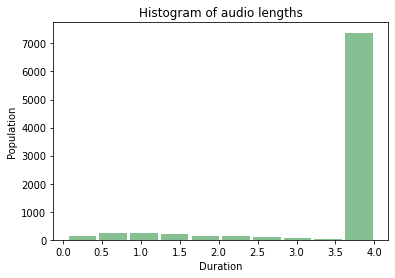

In [9]:
import matplotlib.pyplot as plt

plt.hist(audiodatadf['duration'], rwidth=0.9, color='#86bf91')

plt.xlabel('Duration')
plt.ylabel('Population')
plt.title('Histogram of audio lengths')
plt.grid(False)
plt.show()

### Audio channels

In [10]:
print("Audio channels:\n")
print(audiodatadf.channels.value_counts(normalize=True))

Audio channels:

2    0.915369
1    0.084631
Name: channels, dtype: float64


### Bit depth

In [11]:
print("Bit depths:\n")
print(audiodatadf.bit_depth.value_counts(normalize=True))

Bit depths:

16    0.659414
24    0.315277
32    0.019354
8     0.004924
4     0.001031
Name: bit_depth, dtype: float64


### Sample rate

In [12]:
print("Sample rates:\n")
print(audiodatadf.sample_rate.value_counts(normalize=True))

Sample rates:

44100     0.614979
48000     0.286532
96000     0.069858
24000     0.009391
16000     0.005153
22050     0.005039
11025     0.004466
192000    0.001947
8000      0.001374
11024     0.000802
32000     0.000458
Name: sample_rate, dtype: float64


## 4 Feature Extraction

In [17]:
# Load various imports 
import pandas as pd
import os
import librosa

max_pad_len = 174

def extract_features(file_name):
   
    try:
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        pad_width = max_pad_len - mfccs.shape[1]
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
        
    except Exception as e:
        print("Error encountered while parsing file: ", file_name)
        return None 
     
    return mfccs

features = []

# Iterate through each sound file and extract the features 
for index, row in meta.iterrows():
    
    if index%500==0:
        print("processing element ",index)
    
    file_name = os.path.join(os.path.abspath(fulldatasetpath),'fold'+str(row["fold"]),str(row["slice_file_name"]))
    
    class_label = row["class"]
    data = extract_features(file_name)
    
    features.append([data, class_label])

# Convert into a Panda dataframe 
featuresdf = pd.DataFrame(features, columns=['feature','class_label'])

print('Finished feature extraction from ', len(featuresdf), ' files')

processing element  0
processing element  250
processing element  500
processing element  750
processing element  1000
processing element  1250
processing element  1500
processing element  1750
processing element  2000
processing element  2250
processing element  2500
processing element  2750
processing element  3000
processing element  3250
processing element  3500


E:\anaconda3\envs\plaidML\lib\site-packages\librosa\core\spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1323
  warnings.warn(


processing element  3750
processing element  4000
processing element  4250
processing element  4500
processing element  4750
processing element  5000
processing element  5250
processing element  5500
processing element  5750
processing element  6000
processing element  6250
processing element  6500
processing element  6750
processing element  7000
processing element  7250
processing element  7500
processing element  7750
processing element  8000
processing element  8250


E:\anaconda3\envs\plaidML\lib\site-packages\librosa\core\spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1103
  warnings.warn(
E:\anaconda3\envs\plaidML\lib\site-packages\librosa\core\spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1523
  warnings.warn(


processing element  8500
Finished feature extraction from  8732  files


## 5 Extracted data manipulation

### Save processed data to pickle file

In [19]:
featuresdf.to_pickle('E:\\Xception\\UrbanSound8K\\audio\\processed_data_frame.pkl')

### Load processed data from pickle file

In [4]:
import pandas as pd
featuresdf = pd.read_pickle('E:\\Xception\\UrbanSound8K\\audio\\processed_data_frame.pkl')
print("imported", featuresdf.shape[0],"elements")

imported 8732 elements


### Preprocess data to input the network 

In [5]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# Convert features and corresponding classification labels into numpy arrays
X = np.array(featuresdf.feature.tolist())
y = np.array(featuresdf.class_label.tolist())

# Encode the classification labels
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y)) 

# split the dataset 
from sklearn.model_selection import train_test_split 

x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.2, random_state = 42)

# compute number of output classes
num_labels = featuresdf['class_label'].nunique()

In [53]:
prova = le.fit_transform(y)
for i in range(prova.shape[0]):
    print(prova[i])

3
2
2
2
2
2
2
2
2
1
1
1
1
1
3
3
3
3
3
3
3
3
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
3
3
3
2
2
2
2
2
2
2
2
3
3
3
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
9
9
9
9
9
9
3
3
3
3
3
3
6
3
3
3
3
3
3
3
8
8
8
8
8
8
8
8
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
3
3
3
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
4
4
5
5
5
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
3
3
3
3
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
3
3
3
2
2
2
2
2
2
2
2
9
9
9
9
9
9
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
8
8
8
8
6
1
1
3


7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
6
3
3
3
9
9
9
9
9
9
4
4
4
4
4
4
4
4
4
4
4
3
3
3
9
9
9
9
9
9
1
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
1
1
1
1
1
3
3
3
3
3
3
3
3
1
2
2
2
2
2
2
2
2
3
3
3
3
3
8
8
8
8
8
3
3
3
3
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
1
1
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
4
4
4
4
4
4
4
4
4
3
3
3
3
2
2
2
2
2
2
2
2
5
5
5
5
5
1
1
1
1
1
1
1
2
2
2
2
2
2
2
2
9
9
9
9
9
9
9
9
9
9
9
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
2
2
2
2
2
2
2
2
1
1
1
1
1
1
1
4
4
3
3
3
3
4
4
4
4
4
4
7
7
7
7
7
8
8
8
2
2
2
2
2
2
2
2
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
9
9
9
9
9
9
3
3
3
3
3
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
4
1
3
3
3
2
2
2
2
2
2
2
2
2
2
2


5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
5
5
5
5
5
1
1
1
5
3
3
3
3
3
3
3
3
3
3
3
3
3
4
4
4
4
4
4
4
4
9
9
9
9
9
9
9
9
9
9
9
9
8
8
8
8
1
1
1
9
9
9
9
9
9
9
9
9
9
9
9
3
3
3
3
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
3
7
7
7
7
7
7
3
9
9
9
9
9
9
7
7
7
7
7
7
7
7
7
7
7
9
9
9
9
9
9
8
8
9
9
9
9
9
9
9
9
9
9
9
7
7
7
7
7
7
7
7
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
3
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
2
2
2
2
2
2
2
2
9
9
9
9
9
9
1
1
1
1
1
1
1
1
1


In [54]:
featuresdf.class_label.tolist()

['dog_bark',
 'children_playing',
 'children_playing',
 'children_playing',
 'children_playing',
 'children_playing',
 'children_playing',
 'children_playing',
 'children_playing',
 'car_horn',
 'car_horn',
 'car_horn',
 'car_horn',
 'car_horn',
 'dog_bark',
 'dog_bark',
 'dog_bark',
 'dog_bark',
 'dog_bark',
 'dog_bark',
 'dog_bark',
 'dog_bark',
 'air_conditioner',
 'air_conditioner',
 'air_conditioner',
 'air_conditioner',
 'air_conditioner',
 'air_conditioner',
 'air_conditioner',
 'air_conditioner',
 'air_conditioner',
 'air_conditioner',
 'air_conditioner',
 'air_conditioner',
 'air_conditioner',
 'air_conditioner',
 'air_conditioner',
 'air_conditioner',
 'air_conditioner',
 'air_conditioner',
 'air_conditioner',
 'air_conditioner',
 'air_conditioner',
 'air_conditioner',
 'air_conditioner',
 'air_conditioner',
 'air_conditioner',
 'air_conditioner',
 'air_conditioner',
 'air_conditioner',
 'air_conditioner',
 'air_conditioner',
 'air_conditioner',
 'dog_bark',
 'dog_bark',
 'do

## 6 Model definitions

### Baseline

In [29]:
from keras.models import Model
from keras.layers import SeparableConv2D, ZeroPadding2D, Activation, Dropout, Dense, \
                            Conv2D, MaxPooling2D, Reshape, GRU
from keras.layers.normalization import BatchNormalization
from keras import Input, optimizers

num_rows = X.shape[1]
num_columns = X.shape[2]
num_channels = 1

x_train = x_train.reshape(x_train.shape[0], num_columns, num_rows, num_channels)
x_test = x_test.reshape(x_test.shape[0], num_columns, num_rows, num_channels)

#num_labels = y.shape[2]
#num_labels = 16

def Net():
    
    # input layer
    inputs = Input(shape=(num_columns, num_rows, num_channels))
    
    # DWS-CNN layer 1
    #x = ZeroPadding2D(padding=(2))(inputs)
    # use valid padding since padding is introduced before due to its special form (maybe it's equal to use same padding?)
    x = Conv2D(256,kernel_size=(5,5), strides=(1,1), padding='same')(inputs)
    x = Activation('relu')(x)
    # Batch Normalisation before passing it to the next layer
    x = BatchNormalization()(x)
    # Pooling
    x = MaxPooling2D(pool_size=(1,5), padding='same')(x)
    # Dropout
    x = Dropout(0.25)(x)
    
    # DWS-CNN layer 2
    #x = ZeroPadding2D(padding=(2))(x)
    # use valid padding since padding is introduced before due to its special form
    x = Conv2D(256,kernel_size=(5,5), strides=(1,1), padding='same')(x)
    x = Activation('relu')(x)
    # Batch Normalisation before passing it to the next layer
    x = BatchNormalization()(x)
    # Pooling
    x = MaxPooling2D(pool_size=(1,4), padding='same')(x)
    # Dropout
    x = Dropout(0.25)(x)
    
    # DWS-CNN layer 3
    #x = ZeroPadding2D(padding=(2))(x)
    # use valid padding since padding is introduced before due to its special form
    x = Conv2D(256,kernel_size=(5,5), strides=(1,1), padding='same')(x)
    x = Activation('relu')(x)
    # Batch Normalisation before passing it to the next layer
    x = BatchNormalization()(x)
    # Pooling
    x = MaxPooling2D(pool_size=(1,2), padding='same')(x)
    # Dropout
    x = Dropout(0.25)(x)
    
    x = Reshape((174, 256))(x)
    
    # GRU
    x = GRU(256)(x)
        
    # classifier layer
    outputs = Dense(num_labels,activation='softmax')(x)
    
    
    # model compilation for training
    adam = optimizers.Adam(lr=0.0001)
    model = Model(inputs, outputs)                            
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=["accuracy"])
    
    return model


# create the model
model = Net()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 174, 40, 1)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 174, 40, 256)      6656      
_________________________________________________________________
activation_13 (Activation)   (None, 174, 40, 256)      0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 174, 40, 256)      1024      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 174, 8, 256)       0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 174, 8, 256)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 174, 8, 256)       1638656   
__________

### TO BE FIXED

In [10]:
from keras.models import Model
from keras.layers import SeparableConv2D, ZeroPadding2D, Activation, Dropout, Dense, \
                            Conv2D, MaxPooling2D, GlobalAveragePooling2D, Reshape, Permute
from keras.layers.normalization import BatchNormalization
from keras import Input, optimizers

num_rows = X.shape[1]
num_columns = X.shape[2]
num_channels = 1

x_train = x_train.reshape(x_train.shape[0], num_columns, num_rows, num_channels)
x_test = x_test.reshape(x_test.shape[0], num_columns, num_rows, num_channels)

#num_labels = yy.shape[1]

def Net(dilated_kernel, dilation, dilated_padding):
    
    # input layer
    inputs = Input(shape=(num_columns, num_rows, num_channels))
    
    # DWS-CNN layer 1
    x = ZeroPadding2D(padding=(2))(inputs)
    # use valid padding since padding is introduced before since it has a special form
    x = SeparableConv2D(256,kernel_size=(5,5), strides=(1,1), padding='valid')(x)
    x = Activation('relu')(x)
    # Batch Normalisation before passing it to the next layer
    x = BatchNormalization()(x)
    # Pooling
    x = MaxPooling2D(pool_size=(1,5), strides=(1,5), padding='valid')(x)
    # Dropout
    x = Dropout(0.25)(x)
    
    # DWS-CNN layer 2
    x = ZeroPadding2D(padding=(2))(x)
    # use valid padding since padding is introduced before since it has a special form
    x = SeparableConv2D(256,kernel_size=(5,5), strides=(1,1), padding='valid')(x)
    x = Activation('relu')(x)
    # Batch Normalisation before passing it to the next layer
    x = BatchNormalization()(x)
    # Pooling
    x = MaxPooling2D(pool_size=(1,4), strides=(1,4), padding='valid')(x)
    # Dropout
    x = Dropout(0.25)(x)
    
    # DWS-CNN layer 3
    x = ZeroPadding2D(padding=(2))(x)
    # use valid padding since padding is introduced before since it has a special form
    x = SeparableConv2D(256,kernel_size=(5,5), strides=(1,1), padding='valid')(x)
    x = Activation('relu')(x)
    # Batch Normalisation before passing it to the next layer
    x = BatchNormalization()(x)
    # Pooling
    x = MaxPooling2D(pool_size=(1,2), strides=(1,2), padding='valid')(x)
    # Dropout
    x = Dropout(0.25)(x)
    
    x = Permute((1,3,2))(x)
    
    # DIL-CNN 
    x = ZeroPadding2D(padding=(dilated_padding*dilation, 0))(x)
    x = Conv2D(256, kernel_size=dilated_kernel, dilation_rate=(dilation, 1))(x)#, strides=(1,3))(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    initializer = keras.initializers.Ones()
    x = Conv2D(256, (1,1), strides=(1,3), kernel_initializer=initializer, trainable = False)(x)
    #x = MaxPooling2D(pool_size=(1,3), strides=(1,3), padding='valid')(x)
    
    #x = Reshape((174, 256))(x)
    
    # classifier layer
    x = GlobalAveragePooling2D(name='avg_pool')(x)
    outputs = Dense(num_labels,activation='sigmoid')(x)
    
    # model compilation for training
    adam = optimizers.Adam(lr=0.0001)
    model = Model(inputs, outputs)                            
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
    
    return model


# create the model
dilated_kernel = (3,3)
dilation = (10)
dilated_padding = 1
model = Net(dilated_kernel,dilation,dilated_padding)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 174, 40, 1)        0         
_________________________________________________________________
zero_padding2d_12 (ZeroPaddi (None, 178, 44, 1)        0         
_________________________________________________________________
separable_conv2d_10 (Separab (None, 174, 40, 256)      537       
_________________________________________________________________
activation_11 (Activation)   (None, 174, 40, 256)      0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 174, 40, 256)      1024      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 174, 8, 256)       0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 174, 8, 256)       0         
__________

## Train the model

In [30]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
from datetime import datetime 

num_epochs = 250
# low batch size due to memory maximum dimension, modify if using smaller dataset
num_batch_size = 16

callbacks = [ModelCheckpoint(filepath='E:\\Xception\\UrbanSound8K\\model-{val_loss:.2f}.h5', 
                               verbose=1, save_best_only=True, monitor="val_loss"),
                EarlyStopping(monitor='val_loss', patience=30)]

start = datetime.now()

#y_train = y_train.reshape(y_train.shape[0], 1024, 16)
#y_test = y_test.reshape(y_test.shape[0], 1024, 16)

history = model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_split=0.16, verbose=1, callbacks=callbacks)

duration = datetime.now() - start
print("Training completed in time: ", duration)

Train on 5867 samples, validate on 1118 samples
Epoch 1/250


INFO:plaidml:Analyzing Ops: 4238 of 13865 operations complete
INFO:plaidml:Analyzing Ops: 10811 of 13865 operations complete


5856/5867 [============================>.] - ETA: 0s - loss: 2.1285 - acc: 0.1839

INFO:plaidml:Analyzing Ops: 3926 of 13865 operations complete
INFO:plaidml:Analyzing Ops: 10719 of 13865 operations complete


5867/5867 [==============================] - 606s 103ms/step - loss: 2.1284 - acc: 0.1837 - val_loss: 2.2250 - val_acc: 0.1637

Epoch 00001: val_loss improved from inf to 2.22499, saving model to E:\Xception\UrbanSound8K\model-2.22.h5
Epoch 2/250
5867/5867 [==============================] - 116s 20ms/step - loss: 2.0398 - acc: 0.2154 - val_loss: 2.0456 - val_acc: 0.2066

Epoch 00002: val_loss improved from 2.22499 to 2.04557, saving model to E:\Xception\UrbanSound8K\model-2.05.h5
Epoch 3/250
5867/5867 [==============================] - 116s 20ms/step - loss: 1.9955 - acc: 0.2194 - val_loss: 2.0159 - val_acc: 0.1977

Epoch 00003: val_loss improved from 2.04557 to 2.01591, saving model to E:\Xception\UrbanSound8K\model-2.02.h5
Epoch 4/250
5867/5867 [==============================] - 116s 20ms/step - loss: 1.9398 - acc: 0.2419 - val_loss: 1.9048 - val_acc: 0.2308

Epoch 00004: val_loss improved from 2.01591 to 1.90484, saving model to E:\Xception\UrbanSound8K\model-1.90.h5
Epoch 5/250
586

5867/5867 [==============================] - 117s 20ms/step - loss: 1.0753 - acc: 0.6317 - val_loss: 1.0576 - val_acc: 0.6413

Epoch 00036: val_loss improved from 1.09860 to 1.05763, saving model to E:\Xception\UrbanSound8K\model-1.06.h5
Epoch 37/250
5867/5867 [==============================] - 117s 20ms/step - loss: 1.0692 - acc: 0.6281 - val_loss: 1.1152 - val_acc: 0.6073

Epoch 00037: val_loss did not improve from 1.05763
Epoch 38/250
5867/5867 [==============================] - 117s 20ms/step - loss: 1.0510 - acc: 0.6359 - val_loss: 1.0348 - val_acc: 0.6494

Epoch 00038: val_loss improved from 1.05763 to 1.03479, saving model to E:\Xception\UrbanSound8K\model-1.03.h5
Epoch 39/250
5867/5867 [==============================] - 117s 20ms/step - loss: 1.0494 - acc: 0.6358 - val_loss: 1.0525 - val_acc: 0.6485

Epoch 00039: val_loss did not improve from 1.03479
Epoch 40/250
5867/5867 [==============================] - 117s 20ms/step - loss: 1.0356 - acc: 0.6344 - val_loss: 1.0824 - val_ac


Epoch 00117: val_loss improved from 0.74968 to 0.67321, saving model to E:\Xception\UrbanSound8K\model-0.67.h5
Epoch 118/250
5867/5867 [==============================] - 118s 20ms/step - loss: 0.6503 - acc: 0.7803 - val_loss: 0.7610 - val_acc: 0.7370

Epoch 00118: val_loss did not improve from 0.67321
Epoch 119/250
5867/5867 [==============================] - 118s 20ms/step - loss: 0.6179 - acc: 0.7912 - val_loss: 0.6999 - val_acc: 0.7612

Epoch 00119: val_loss did not improve from 0.67321
Epoch 120/250
5867/5867 [==============================] - 118s 20ms/step - loss: 0.5962 - acc: 0.7965 - val_loss: 0.6896 - val_acc: 0.7692

Epoch 00120: val_loss did not improve from 0.67321
Epoch 121/250
5867/5867 [==============================] - 118s 20ms/step - loss: 0.5638 - acc: 0.8118 - val_loss: 0.6693 - val_acc: 0.7567

Epoch 00121: val_loss improved from 0.67321 to 0.66935, saving model to E:\Xception\UrbanSound8K\model-0.67.h5
Epoch 122/250
5867/5867 [==============================] - 1


Epoch 00158: val_loss did not improve from 0.52140
Epoch 159/250
5867/5867 [==============================] - 118s 20ms/step - loss: 0.4175 - acc: 0.8614 - val_loss: 0.6094 - val_acc: 0.8032

Epoch 00159: val_loss did not improve from 0.52140
Epoch 160/250
5867/5867 [==============================] - 117s 20ms/step - loss: 0.4233 - acc: 0.8573 - val_loss: 0.5793 - val_acc: 0.8023

Epoch 00160: val_loss did not improve from 0.52140
Training completed in time:  5:21:40.642122


In [31]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(x_test, y_test, batch_size=num_batch_size)
print("test loss, test acc:", results)

Evaluate on test data
1744/1747 [============================>.] - ETA: 0s

INFO:plaidml:Analyzing Ops: 3977 of 5504 operations complete


1747/1747 [==============================] - 83s 48ms/step
test loss, test acc: [0.5247644930481553, 0.8236977676016027]


## Plot Results

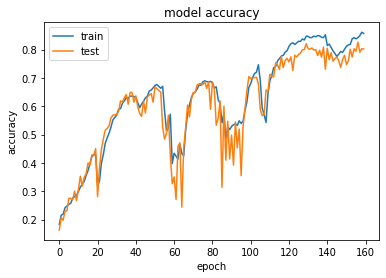

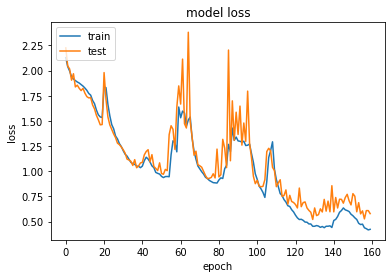

In [32]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [57]:
import sklearn.metrics 
from sklearn.metrics import classification_report, confusion_matrix

classnames = ["air conditioner", "car horn", "children playing", "dog bark", "drilling", "engine idling", "gun shot", "jackhammer", "siren", "street music"]

preds = model.predict(x_test,verbose=1)

Ypred = np.argmax(preds, axis=1)
Ytest = np.argmax(y_test, axis=1)

print(classification_report(Ytest, Ypred, labels=None, target_names=classnames, digits=3))

                  precision    recall  f1-score   support

 air conditioner      0.925     0.916     0.921       203
        car horn      0.920     0.802     0.857        86
children playing      0.593     0.874     0.706       183
        dog bark      0.856     0.682     0.759       201
        drilling      0.821     0.757     0.788       206
   engine idling      0.894     0.917     0.905       193
        gun shot      0.759     0.875     0.813        72
      jackhammer      0.897     0.837     0.866       208
           siren      0.894     0.867     0.880       165
    street music      0.806     0.757     0.780       230

        accuracy                          0.824      1747
       macro avg      0.836     0.828     0.828      1747
    weighted avg      0.838     0.824     0.826      1747

